# Preface

The purpose of this project is to analyze how historical extreme heat events affected different populations in Mexico, Spain, and India. Specifically, we are interested in the 1998 heatwave in Mexico, 2003 European heatwave that significantly impacted Spain, and the 2015 heatwave in India. We also take a brief look at affects on agricultural yields.  

# Setup

In [ ]:
%pip install wbdata

import wbdata
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
pd.options.plotting.backend = 'plotly'

In [ ]:
#wbdata.get_countries()

# We will be using ESP, MEX, IND

In [ ]:
#wbdata.get_sources()

# We will be using source 40, "Population estimates and projections"

Reference the variables returned by *indicators* for data exploration.



In [ ]:
SOURCE = 40 # "Population estimates and projections"

indicators = wbdata.get_indicators(source=SOURCE)
indicators

id                 name
-----------------  -------------------------------------------------------------------
SH.DTH.0509        Number of deaths ages 5-9 years
SH.DTH.0514        Number of deaths ages 5-14 years
SH.DTH.1014        Number of deaths ages 10-14 years
SH.DTH.1019        Number of deaths ages 10-19 years
SH.DTH.1519        Number of deaths ages 15-19 years
SH.DTH.2024        Number of deaths ages 20-24 years
SH.DTH.IMRT        Number of infant deaths
SH.DTH.IMRT.FE     Number of infant deaths, female
SH.DTH.IMRT.MA     Number of infant deaths, male
SH.DTH.MORT        Number of under-five deaths
SH.DTH.MORT.FE     Number of under-five deaths, female
SH.DTH.MORT.MA     Number of under-five deaths, male
SH.DTH.NMRT        Number of neonatal deaths
SH.DYN.0509        Probability of dying among children ages 5-9 years (per 1,000)
SH.DYN.0514        Probability of dying at age 5-14 years (per 1,000 children age 5)
SH.DYN.1014        Probability of dying among adolescents ages 1

# [A] Population Statistics

Write a population function that will return the population count for the input country in the given year.

In [ ]:
# Population Function
# Retrieve country codes from WBData and store them in a dictionary
countries = wbdata.get_countries()
country_dict = {}
for country in countries:
    country_code = country['id']
    country_name = country['name']
    country_dict[country_name] = country_code

# Convert single-digit numbers to two-digit strings
def int_to_str(num):
  if 0 <= num < 10:
        return f"0{num}"
  else:
        return str(num)

# Function to get the population for a specific age range, sex, and country
def population_range(year, sex, age_range, place):
  # Define sex codes for WBData indicators
  sex_codes = {"people": "", "females": "FE", "males": "MA"}
  if sex not in sex_codes:
        raise ValueError("Sex must be one of: 'people', 'females', or 'males'.")
  sex_used = sex_codes[sex]

  #check if the imput is for one single age
  if age_range[0] == age_range[1]:
      same_age = int_to_str(age_range[0])
      indicator_code = f"SP.POP.{same_age}{same_age}.{sex_used}"

  # Handle special cases: 80+ and 0-4 age groups
  if age_range[0] >= 80:
    indicator_code = "SP.POP.80UP." + sex_used
  elif age_range[0] == 0:
    indicator_code = "SP.POP.0004." + sex_used
  else:
    # Format the age range into WBData indicator format
    lower, upper = int_to_str(age_range[0]), int_to_str(age_range[1])
    range_string = lower + upper
    indicator_code = "SP.POP." + range_string + "." + sex_used

  # Retrieve the country code from the dictionary
  country_code = country_dict.get(place)
  if country_code is None:
        raise ValueError(f"Place '{place}' not found. Please check.")

  # Fetch population data from WBData
  df = wbdata.get_dataframe({indicator_code: "Population"},
                              country={country_code: place})

  # Check if the retrieved dataset is empty
  if df.empty:
        raise ValueError(f"No data found for {place} in {year} using indicator '{indicator_code}'.")

  # Convert the dataframe into a usable format
  df = df.squeeze().to_frame().reset_index()

  # Extract the population value for the given year
  matching = df[df["date"] == str(year)]
  if matching.empty:
        raise ValueError(f"No data available for the year {year}.")

  population_total = int(matching["Population"].iloc[0])
  return population_total

# Helper function to distribute population into 5-year age groups
def dict_helper1(year, sex, age_range, place):

  if len(age_range) == 1:
        age_range = [age_range[0], age_range[0]]
  elif age_range[1] < age_range[0]:
        raise ValueError("Please ensure that the second value in the range is greater than the first.")

  # Define 5-year interval groups used in WBData
  minimum_age, maximum_age = age_range
  possible_minimums = list(range(0, 76, 5))
  possible_maximums = list(range(4, 120, 5))

  age_population = {}

  # Loop through each age in the range and assign it to the correct 5-year group
  for age in range(minimum_age, maximum_age + 1):
      range_index = next((i for i, min_val in enumerate(possible_minimums)
                            if min_val <= age <= possible_maximums[i]), None)
  if range_index is not None:
    # Retrieve population for the corresponding 5-year group
      group_population = population_range(year, sex,
                                          [possible_minimums[range_index], possible_maximums[range_index]],
                                           place)
      per_age_population = group_population // 5
      age_population[age] = per_age_population
  else:
      group_population = population_range(year, sex,
                                           [possible_minimums[-1], possible_maximums[-1]],
                                            place)
      per_age_population = group_population // 5
      age_population[age] = per_age_population
  return age_population

# Function to calculate total population for a given age range
def dict_helper(year, sex, age_range, place):
    total = 0
    start_age, end_age = age_range

    if end_age >= 80:
        # If the age range includes 80+, use the separate population indicator
        total += population_range(year, sex, [80, 120], place)

        # Calculate population for ages below 80 separately
        if start_age < 80:
            for x in range(start_age, 80):
                total += sum(dict_helper1(year, sex, [x, x], place).values())
    else:
        # If age range is below 80, calculate using the helper function
        for x in range(start_age, end_age + 1):
            total += sum(dict_helper1(year, sex, [x, x], place).values())

    return total

# Main function to retrieve total population for a given age range, sex, and country
def population(year, sex, age_range, place):
  if place not in country_dict:
        valid_regions = ", ".join(country_dict.keys())
        raise ValueError(f"The region '{place}' is not valid. Valid regions include: {valid_regions}")
  if sex.lower() in ["all", "people", "p", "everyone"]:
    # If "all" is selected, sum both male and female populations
    female_data = dict_helper(year, "females", age_range, place)
    male_data = dict_helper(year, "males", age_range, place)
    total_population = male_data + female_data
  elif sex.lower() in ["female", "females", "f", "fe"]:
    # Retrieve only female population
        female_data = dict_helper(year, "females", age_range, place)
        total_population = female_data
  elif sex.lower() in ["male", "males", "m", "ma"]:
    # Retrieve only male population
        male_data = dict_helper(year, "males", age_range, place)
        total_population = male_data
  else:
        raise ValueError("Sex not recognized. Please use a valid input such as 'people', 'females', or 'males'.")

  return total_population


#example:
population(2010, 'male', [80, 100], 'United States')

4053895

# [A] Population DataFrames

**Below is a function that returns a pandas DataFrame indexed by country and year, with columns giving counts of people in different age-sex groups.**

In [ ]:
def population_dataframe(years, countries, age_groups):
    # Create an empty list to store data
    data = []

    # Loop through countries, years, and age groups
    for country in countries:
        for year in years:
            row = {"Country": country, "Year": year}  # Initialize row for each country-year

            for age_range in age_groups:
                for sex in ["males", "females"]:  # Separate calculations for males and females
                    try:
                        total_population = population(year, sex, age_range, country)
                        row[f"{sex.capitalize()} {age_range[0]}-{age_range[1]}"] = total_population
                    except ValueError:
                        row[f"{sex.capitalize()} {age_range[0]}-{age_range[1]}"] = None  # Handle missing data

            data.append(row)

    # Convert list to DataFrame
    df = pd.DataFrame(data)

    # Set hierarchical index: Country → Year
    df.set_index(["Country", "Year"], inplace=True)

    return df

In [ ]:
# Example usage:
years = [1997, 1998, 1999]
countries = ["India", "Mexico", "Spain"]  # Target countries
age_groups = [(0, 4), (5, 9), (10, 14), (15, 19), (20, 24), (25, 29), (30, 34), (35, 39),
              (40, 44), (45, 49), (50, 54), (55, 59), (60, 64), (65, 69), (70, 74), (75, 79), (80,120)]

population_df = population_dataframe(years, countries, age_groups)
population_df

Males 0-4  Females 0-4  Males 5-9  Females 5-9  Males 10-14  \
Country Year                                                                
India   1997   67718840     61995685   63676030     58649475     59642000   
        1998   68160825     62240620   64176935     59048375     60619355   
        1999   68579810     62502635   64671855     59382580     61452995   
Mexico  1997    5853850      5675040    5730940      5562805      5347190   
        1998    5834630      5652910    5772175      5607255      5417130   
        1999    5810280      5626435    5800855      5642025      5494015   
Spain   1997     965650       910235    1060560      1000320      1210860   
        1998     951865       897380    1049460       990480      1173055   
        1999     948485       894935    1032730       975270      1144160   

              Females 10-14  Males 15-19  Females 15-19  Males 20-24  \
Country Year                                                           
India   1997       54813885     53100150       48780050     47070080   
        1998       55729105     54414595       49940090     48050760   
        1999       56530255     55747490       51130560     49036345   
Mexico  1997        5308500      4872590        5070365      4412740   
        1998        5341090      4912250        5111340      4413695   
        1999        5379255      4968540        5153795      4417770   
Spain   1997        1138890      1537870        1450645      1743625   
        1998        1104235      1472350        1387760      1741875   
        1999        1078010      1406125        1323880      1724400   

              Females 20-24  ...  Males 60-64  Females 60-64  Males 65-69  \
Country Year                 ...                                            
India   1997       43462215  ...     11501875       11857710      8635285   
        1998       44292430  ...     11751395       12155220      8824720   
        1999       45126250  ...     11983105       12415020      9019015   
Mexico  1997        4757240  ...       960620        1055675       739705   
        1998        4784555  ...       993490        1093235       765665   
        1999        4816305  ...      1027305        1131115       792495   
Spain   1997        1650095  ...      1024000        1127425       934520   
        1998        1646760  ...       988820        1086485       953895   
        1999        1630455  ...       936470        1026905       965380   

              Females 65-69  Males 70-74  Females 70-74  Males 75-79  \
Country Year                                                           
India   1997        8993555      5800085        6258955      3351615   
        1998        9280025      5981020        6450540      3466850   
        1999        9567660      6161725        6655065      3590345   
Mexico  1997         820810       542930         603080       359490   
        1998         852090       563635         627305       377220   
        1999         884810       584155         652310       395430   
Spain   1997        1080490       738415         934525       477415   
        1998        1098120       752675         949170       508220   
        1999        1108190       768435         966700       537620   

              Females 75-79  Males 80-120  Females 80-120  
Country Year                                               
India   1997        3963630       2311841         3317904  
        1998        4079105       2408252         3443241  
        1999        4202320       2512186         3571103  
Mexico  1997         410815        399278          505583  
        1998         428740        418365          529749  
        1999         447070        440314          555871  
Spain   1997         710875        470813          942918  
        1998         741335        477670          964002  
        1999         771290        483963          981406  

[9 rows x 34 columns]

**Below are functions that return birth and death rates for a given country and a list of years.**

In [ ]:
def get_birth_rate_data(country, years):
    """
    Retrieves birth rate data from the World Bank for the specified country and years.

    Parameters:
    - country (str): a country code (e.g., "IND")
    - years (list of int): List of years to filter (e.g., [2014, 2015, 2016]).

    Returns:
    - pd.DataFrame: A DataFrame with birth rate data for the given country and years.
    """
    birth_label = {"SP.DYN.CBRT.IN": "Birth Rate"}

    # Fetch data from the World Bank
    df = wbdata.get_dataframe(birth_label, country=country, parse_dates=True)

    # Filter for specified years
    df = df[df.index.year.isin(years)]

    # Add a name to the dataframe
    df.index.rename(f"{country}", inplace=True)

    return df

In [ ]:
def get_death_rate_data(country, years):
    """
    Retrieves death rate data from the World Bank for the specified country and years.

    Parameters:
    - country (str): a country code (e.g., "IND")
    - years (list of int): List of years to filter (e.g., [2014, 2015, 2016]).

    Returns:
    - pd.DataFrame: A DataFrame with death rate data for the given country and years.
    """
    death_label = {"SP.DYN.CDRT.IN":"Death Rate"}

    # Fetch data from the World Bank
    df = wbdata.get_dataframe(death_label, country=country, parse_dates=True)

    # Filter for specified years
    df = df[df.index.year.isin(years)]

    # Add a name to the dataframe
    df.index.rename(f"{country}", inplace=True)

    return df

**Using these functions, we compare birth and death rates between countries.**

In [ ]:
# Compare the birth rate of the three countries before, during, and after their extreme-heat event year.

esp1, ind1, mex1 = get_birth_rate_data("ESP", [2002, 2003, 2004]), \
                get_birth_rate_data("IND", [2014, 2015, 2016]), \
                get_birth_rate_data("MEX", [1997, 1998, 1999])

esp1, ind1, mex1

(            Birth Rate
 ESP                   
 2004-01-01        10.6
 2003-01-01        10.4
 2002-01-01        10.1,
             Birth Rate
 IND                   
 2016-01-01      18.514
 2015-01-01      18.765
 2014-01-01      19.049,
             Birth Rate
 MEX                   
 1999-01-01      24.618
 1998-01-01      24.925
 1997-01-01      25.511)

We expected to see that birth rates in the year following the extreme-heat event would drop. This is only true for India and Mexico.

In [ ]:
# Compare the death rate of the three countries before, during, and after their extreme-heat event year.

esp2, ind2, mex2 = get_death_rate_data("ESP", [2002, 2003, 2004]), \
                  get_death_rate_data("IND", [2014, 2015, 2016]), \
                  get_death_rate_data("MEX", [1997, 1998, 1999])

esp2, ind2, mex2

(            Death Rate
 ESP                   
 2004-01-01         8.6
 2003-01-01         9.1
 2002-01-01         8.8,
             Death Rate
 IND                   
 2016-01-01       6.603
 2015-01-01       6.670
 2014-01-01       6.790,
             Death Rate
 MEX                   
 1999-01-01       5.036
 1998-01-01       5.086
 1997-01-01       5.152)

We expected to see that the highest death rate in the 3-year periods would be in the second year, the year of the extreme heat event. Turns out, this is only true for Spain.

Below is a function to help with exploring fertility data.

In [ ]:
#Create a data frame for a function that returns fertility rates (births per woman) for all three countries
def get_fertility_rate_data(country, years):
    """
    Retrieves fertility rate data from the World Bank for the specified country and years.

    Parameters:
    - country (str): a country code (e.g., "IND")
    - years (list of int): List of years to filter (e.g., [2014, 2015, 2016]).

    Returns:
    - pd.DataFrame: A DataFrame with fertility rate data for the given country and years.
    """
    fertility_label = {"SP.DYN.TFRT.IN":"Fertility Rate"}

    # Fetch data from the World Bank
    df = wbdata.get_dataframe(fertility_label, country=country, parse_dates=True)

    df = df[df.index.year.isin(years)]

    # Add a name to the dataframe
    df.index.rename(f"{country}", inplace=True)

    return df

# [A] Unit tests

Ensure functions return expected results.

In [ ]:
# This unit test assures that male population in India from the age range 0-4 is equal to 67718840 in the year 1990.
assert(population(1990, 'male',  [0, 4], 'India') == 64462215), 'Error'

In [ ]:
#This unit test assures that the total world population in the year 1990 was greater than 5,000,000,000.
assert(population(1990, 'all', [0,80], 'World') > 5000000000), 'Error'

In [ ]:
#This unit test assures that the total population of women was greater than the total population of men in Mexico in the year 2000.
assert(population(2000, 'females', [0,80], 'Mexico') > population(2000, 'males', [0,80], 'Mexico')), 'Error'

In [ ]:
#This unit test assures that the function returns birth rates for the years 2002, 2003, and 2004 for the country Spain.
assert(get_birth_rate_data("ESP", [2002, 2003, 2004]) is not None)

In [ ]:
#This unit assures that the function returns death rates for the World from the year 1997-1999.
assert(get_death_rate_data("WLD", [1997, 1998, 1999]) is not None)

# [B] Population Pyramids

A python function that takes as input a pandas DataFrame with columns providing counts of people by age-sex groups, and constructs a “population pyramid” graph for visualizing the data.

In [ ]:
def plot_population_pyramid(country, year, age_groups):
    """
    Plots a population pyramid based on given country, year, and age groups (no need to create a dataframe first).

    Parameters:
    - country (str): Country name (e.g., 'Spain').
    - year (int): Year for the population data.
    - age_groups (list of tuples): List of age ranges (e.g., [(0, 4), (5, 9), (10, 14)]).
    """
    # This generates the population dataframe for the given parameters
    pop_df = population_dataframe([year], [country], age_groups)

    # This plots the population pyramid using the generated dataframe
    help_plot_population_pyramid(pop_df, country, year)

def help_plot_population_pyramid(df, country, year):
    """
    Plots a population pyramid based on a DataFrame containing population counts
    for various age-sex groups.

    Parameters:
    - df (pd.DataFrame): DataFrame with age-sex population counts.
    - country (str): Country name (e.g., 'Spain').
    - year (int): Year for the population data.
    """
    # Filter the DataFrame for the specified country and year
    df_filtered = df.loc[(country, year)]

    # Prepare the male and female data by separating the age-sex groups
    male_columns = [col for col in df_filtered.index if "Male" in col]
    female_columns = [col for col in df_filtered.index if "Female" in col]

    # Get population values for males and females
    male_data = df_filtered[male_columns].values
    female_data = df_filtered[female_columns].values

    # Replace None or NaN values with 0 to avoid TypeError
    male_data = np.nan_to_num(male_data)
    female_data = np.nan_to_num(female_data)

    # Create age group labels
    age_groups = [col.split()[-1] for col in male_columns]

    # Create the pyramid plot
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(age_groups, -female_data, color='pink', label='Females')
    ax.barh(age_groups, male_data, color='purple', label='Males')

    ax.set_xlabel('Population')
    ax.set_ylabel('Age Group')
    ax.set_title(f'Population Pyramid for {country} in {year}')
    ax.legend()

    plt.show()

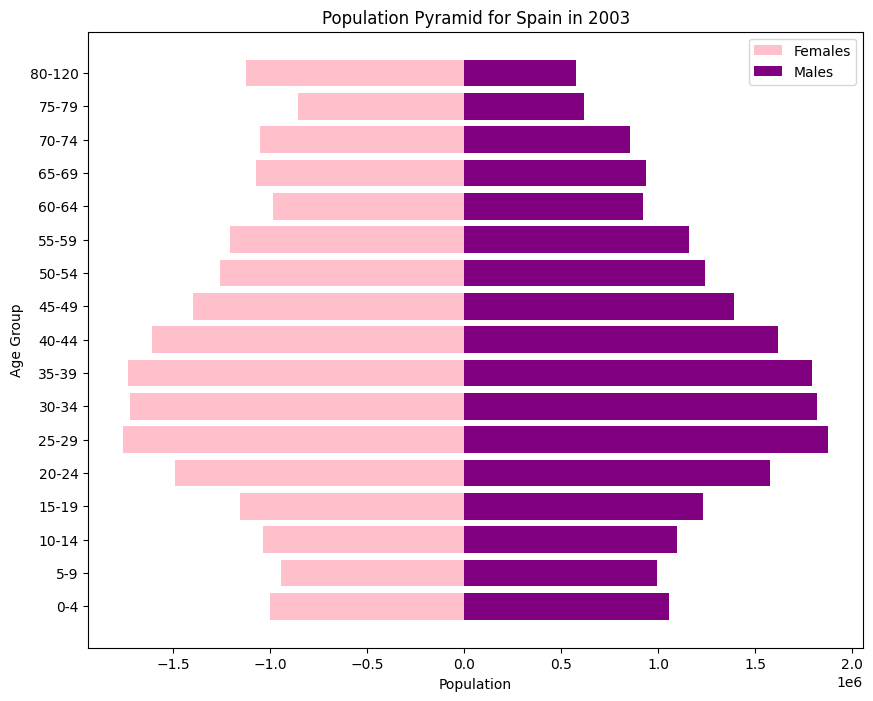

In [ ]:
# Remember that "age_groups" was previously defined
plot_population_pyramid('Spain', 2003, age_groups)

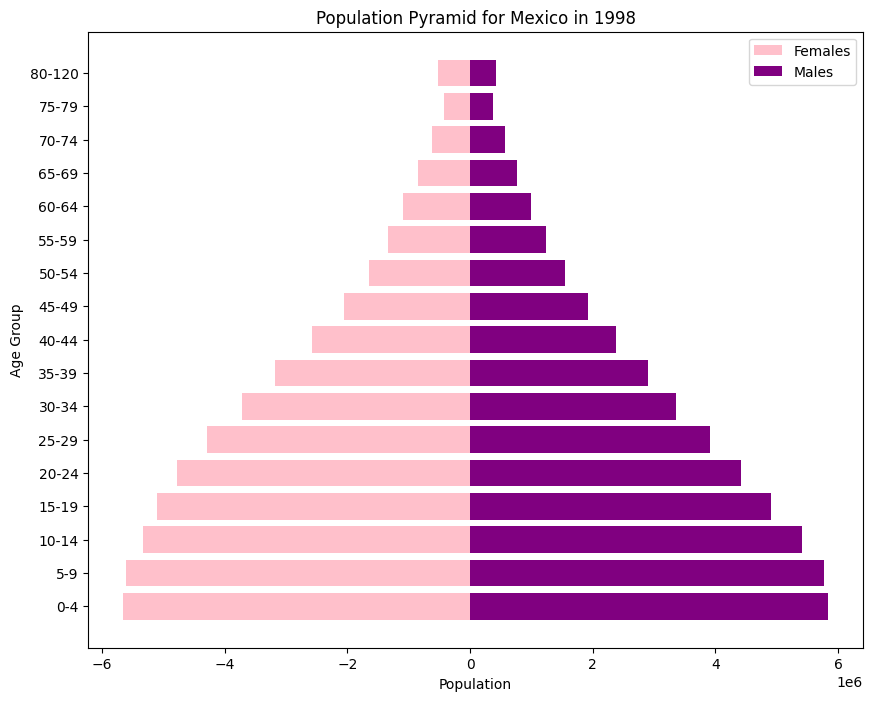

In [ ]:
plot_population_pyramid('Mexico', 1998, age_groups)

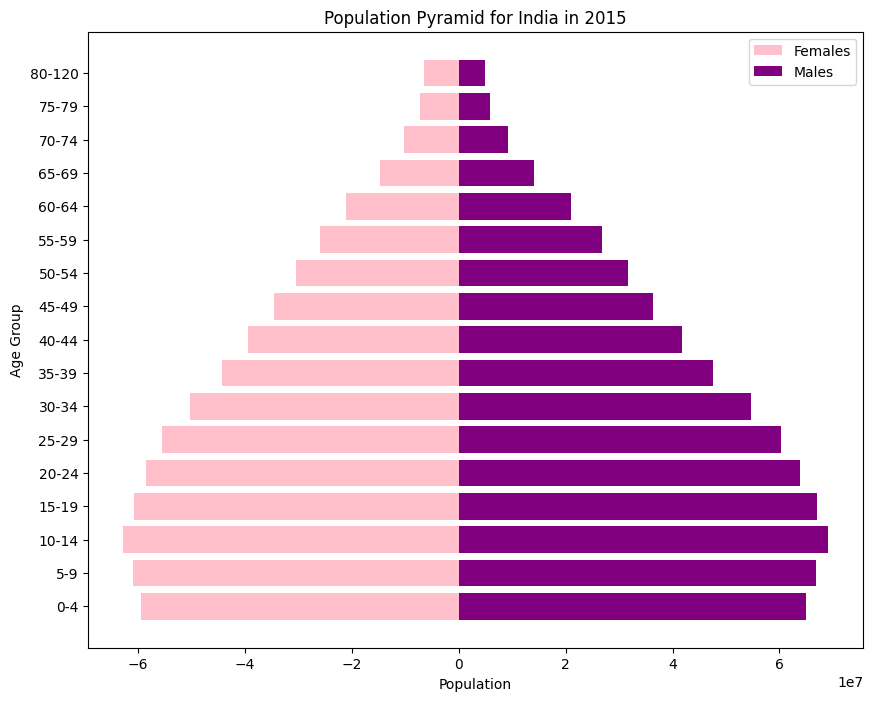

In [ ]:
plot_population_pyramid('India', 2015, age_groups)

# [C] Other Visualizations

**This section will plot the birth and death rates for the 3 countries amongst each other.**

In [ ]:
# Create dataframes to make plots with
esp_birth, ind_birth, mex_birth = get_birth_rate_data("ESP", range(1997,2017)), \
                                  get_birth_rate_data("IND", range(1997,2017)), \
                                  get_birth_rate_data("MEX", range(1997,2017))

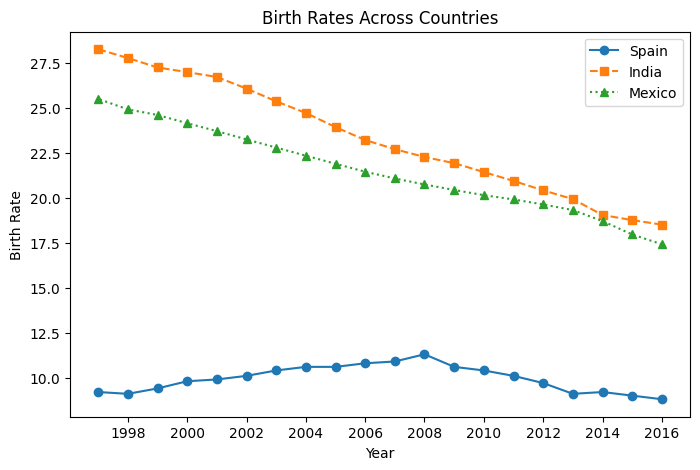

In [ ]:
# Extract data from above
years_esp, birth_esp = esp_birth.index, esp_birth["Birth Rate"]
years_ind, birth_ind = ind_birth.index, ind_birth["Birth Rate"]
years_mex, birth_mex = mex_birth.index, mex_birth["Birth Rate"]

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(years_esp, birth_esp, marker="o", linestyle="-", label="Spain")
plt.plot(years_ind, birth_ind, marker="s", linestyle="--", label="India")
plt.plot(years_mex, birth_mex, marker="^", linestyle=":", label="Mexico")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Birth Rate")
plt.title("Birth Rates Across Countries")
plt.legend()

# Show plot
plt.show()

In [ ]:
# Create dataframes to make plots with
esp_death, ind_death, mex_death = get_death_rate_data("ESP", range(1997, 2017)), \
                                  get_death_rate_data("IND", range(1997, 2017)), \
                                  get_death_rate_data("MEX", range(1997, 2017))

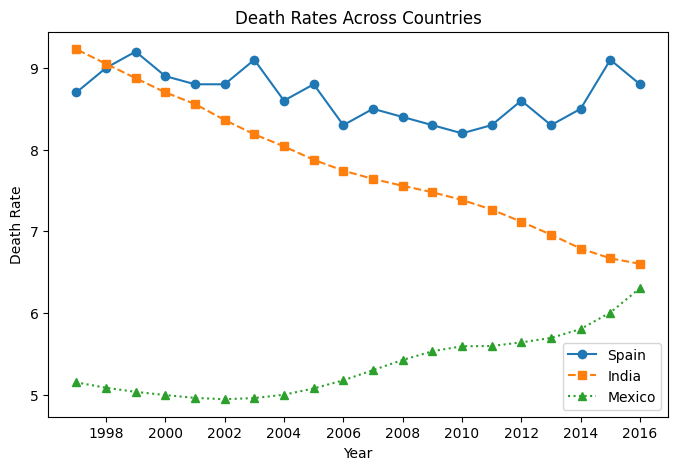

In [ ]:
import matplotlib.pyplot as plt

# Extract data from new death rate dataframes
years_esp, death_esp = esp_death.index, esp_death["Death Rate"]
years_ind, death_ind = ind_death.index, ind_death["Death Rate"]
years_mex, death_mex = mex_death.index, mex_death["Death Rate"]

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(years_esp, death_esp, marker="o", linestyle="-", label="Spain")
plt.plot(years_ind, death_ind, marker="s", linestyle="--", label="India")
plt.plot(years_mex, death_mex, marker="^", linestyle=":", label="Mexico")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Death Rate")
plt.title("Death Rates Across Countries")
plt.legend()

# Show plot
plt.show()

Below is code that plots fertility rates for the three countries.

In [ ]:
# Get the fertility data for dates of interest
esp_fertility, ind_fertility, mex_fertility = get_fertility_rate_data("ESP", range(1997, 2017)), \
                                  get_fertility_rate_data("IND", range(1997, 2017)), \
                                  get_fertility_rate_data("MEX", range(1997, 2017))


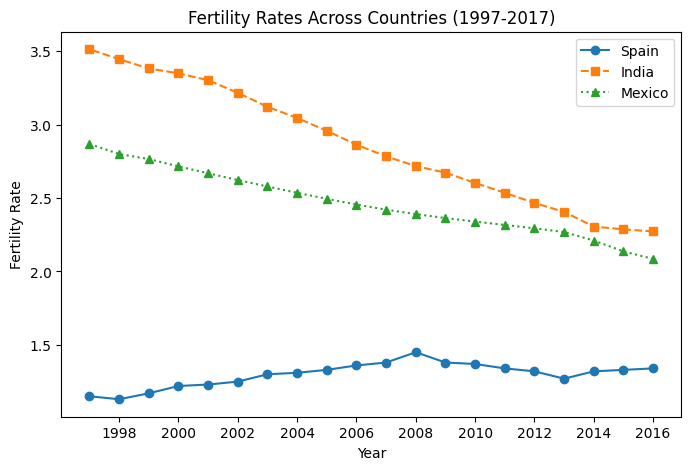

In [ ]:
# Extract data
years_esp, fertility_esp = esp_fertility.index, esp_fertility["Fertility Rate"]
years_ind, fertility_ind = ind_fertility.index, ind_fertility["Fertility Rate"]
years_mex, fertility_mex = mex_fertility.index, mex_fertility["Fertility Rate"]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(years_esp, fertility_esp, marker="o", linestyle="-", label="Spain")
plt.plot(years_ind, fertility_ind, marker="s", linestyle="--", label="India")
plt.plot(years_mex, fertility_mex, marker="^", linestyle=":", label="Mexico")

# Labels
plt.xlabel("Year")
plt.ylabel("Fertility Rate")
plt.title("Fertility Rates Across Countries (1997-2017)")
plt.legend()

plt.show()

**Below is further analysis on factors that might be impacted by extreme heat.**

Perhaps extreme heat events will decrease life expectancy?

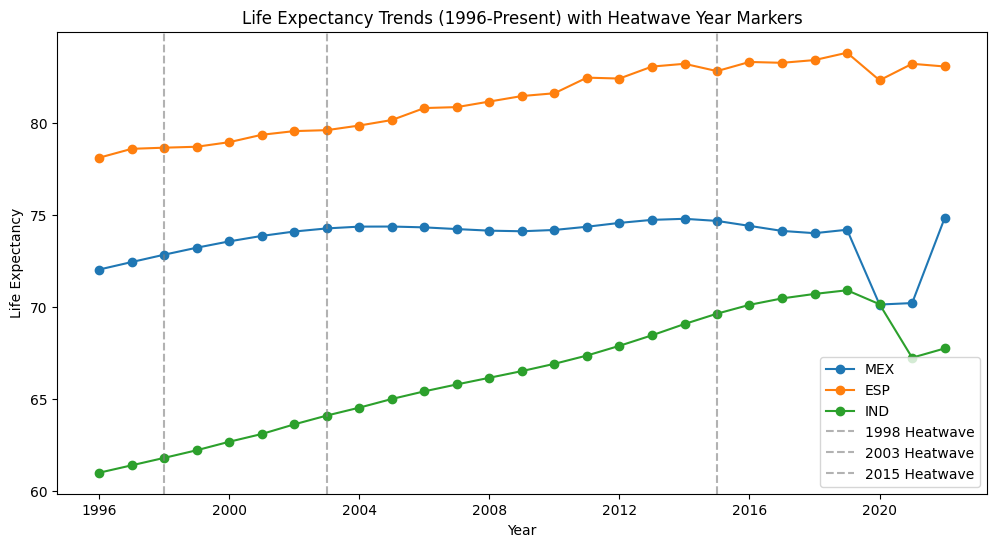

In [ ]:
# Define the indicator for Life Expectancy
indicators = {"SP.DYN.LE00.IN": "Life Expectancy"}

# Define countries and their heatwave years
heatwave_events = {
    "MEX": 1998,  # Mexico
    "ESP": 2003,  # Spain
    "IND": 2015   # India
}

# Define the start year for filtering
start_year = 1996

# Fetch data for each country (1996 - Present)
dataframes = []
for country in heatwave_events.keys():
    df = wbdata.get_dataframe(indicators, country=country, parse_dates=True)
    df["Country"] = country
    dataframes.append(df)

# Combine data from all countries
df_life_expectancy = pd.concat(dataframes).reset_index()

# Convert "date" column to datetime format
df_life_expectancy["date"] = pd.to_datetime(df_life_expectancy["date"])

# Filter data from 1990 onwards
df_life_expectancy = df_life_expectancy[df_life_expectancy["date"].dt.year >= start_year]

# Plot Life Expectancy Trends
plt.figure(figsize=(12, 6))
for country in heatwave_events.keys():
    subset = df_life_expectancy[df_life_expectancy["Country"] == country]
    plt.plot(subset["date"], subset["Life Expectancy"], marker='o', label=country)

# Mark Heatwave Years on the Graph
for year in heatwave_events.values():
    plt.axvline(pd.to_datetime(str(year)), color="gray", linestyle="--", alpha=0.6, label=f"{year} Heatwave")

plt.xlabel("Year")
plt.ylabel("Life Expectancy")
plt.title("Life Expectancy Trends (1996-Present) with Heatwave Year Markers")
plt.legend()
plt.show()


How is migration affected when there is an extreme heat event?

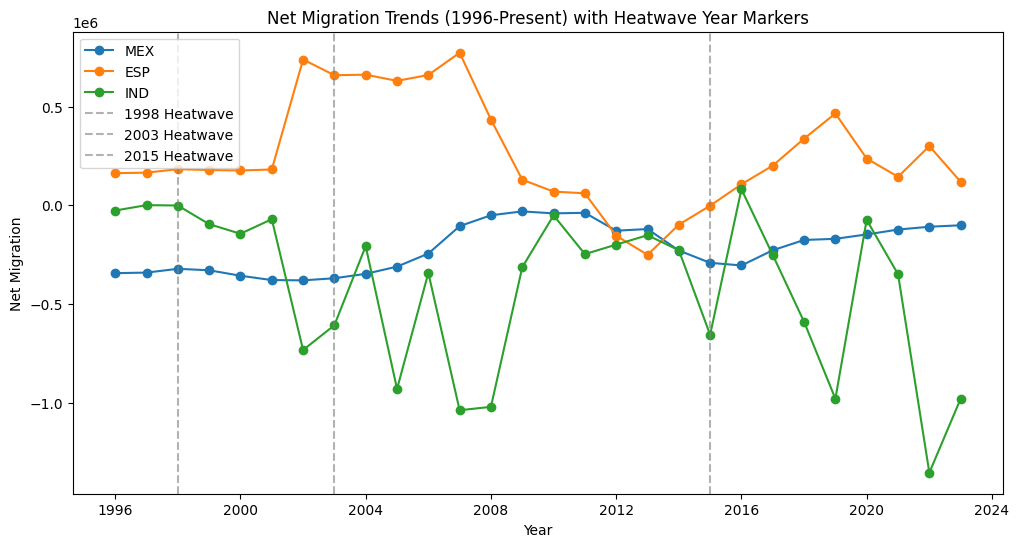

In [ ]:
# Define the indicator for Net Migration
migration = {"SM.POP.NETM": "Net Migration"}

# Define countries and their heatwave years
heatwave_events = {
    "MEX": 1998,  # Mexico
    "ESP": 2003,  # Spain
    "IND": 2015   # India
}

# Define the start year for filtering
start_year = 1996

# Fetch data for each country (1996 - Present)
dataframes = []
for country in heatwave_events.keys():
    df = wbdata.get_dataframe(migration, country=country, parse_dates=True)
    df["Country"] = country
    dataframes.append(df)

# Combine data from all countries
df_net_migration = pd.concat(dataframes).reset_index()

# Convert "date" column to datetime format
df_net_migration["date"] = pd.to_datetime(df_net_migration["date"])

# Filter data from 1996 onwards
df_net_migration = df_net_migration[df_net_migration["date"].dt.year >= start_year]

# Plot Net Migration Trends
plt.figure(figsize=(12, 6))
for country in heatwave_events.keys():
    subset = df_net_migration[df_net_migration["Country"] == country]
    plt.plot(subset["date"], subset["Net Migration"], marker='o', label=country)

# Mark Heatwave Years on the Graph
for year in heatwave_events.values():
    plt.axvline(pd.to_datetime(str(year)), color="gray", linestyle="--", alpha=0.6, label=f"{year} Heatwave")

plt.xlabel("Year")
plt.ylabel("Net Migration")
plt.title("Net Migration Trends (1996-Present) with Heatwave Year Markers")
plt.legend()
plt.show()

Interestingly, migration dropped significantly in India (2015). With further research, this could be attributed to how in India, most migration is from rural to urban areas for jobs. Since the heatwave impacted the urban areas severely, much less migration occured in this year.

# [C] Agricultural Supply

**This section will investigate the affect of extreme heat on agricultural production.**

In [ ]:
# wbdata.get_indicators(topic=1)
# This section will use data from the "Agriculture & Rural Development" topic of wbdata.

The code below plots the cereal yield of all 3 countries.

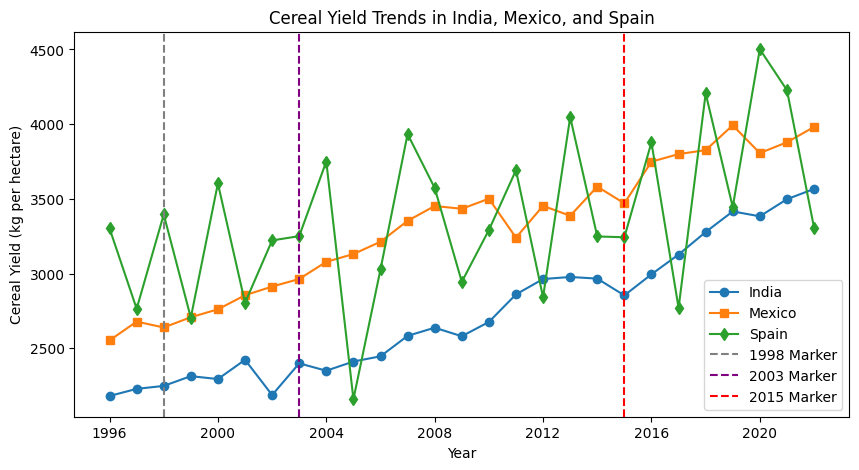

In [ ]:
vars = {"AG.YLD.CREL.KG": "Cereal Yield"}
use_india = ["IND"]
use_mexico = ["MEX"]
use_spain = ["ESP"]

# Making the dataframes
cereals_india = wbdata.get_dataframe(vars, country=use_india, parse_dates=True).reset_index()
cereals_mexico = wbdata.get_dataframe(vars, country=use_mexico, parse_dates=True).reset_index()
cereals_spain = wbdata.get_dataframe(vars, country=use_spain, parse_dates=True).reset_index()

# Filter for years after 1995
cereals_india = cereals_india[cereals_india['date'].dt.year > 1995]
cereals_mexico = cereals_mexico[cereals_mexico['date'].dt.year > 1995]
cereals_spain = cereals_spain[cereals_spain['date'].dt.year > 1995]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(cereals_india['date'], cereals_india["Cereal Yield"], marker='o', linestyle='-', label="India")
plt.plot(cereals_mexico['date'], cereals_mexico["Cereal Yield"], marker='s', linestyle='-', label="Mexico")
plt.plot(cereals_spain['date'], cereals_spain["Cereal Yield"], marker='d', linestyle='-', label="Spain")

# These asymptotes mark the year of each country's heatwave event
plt.axvline(pd.Timestamp("1998-01-01"), color='gray', linestyle='--', label="1998 Marker")
plt.axvline(pd.Timestamp("2003-01-01"), color='purple', linestyle='--', label="2003 Marker")
plt.axvline(pd.Timestamp("2015-01-01"), color='red', linestyle='--', label="2015 Marker")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Cereal Yield (kg per hectare)")
plt.title("Cereal Yield Trends in India, Mexico, and Spain")

plt.legend()
plt.show()

We want to see India on its own and investigate why there is a big drop in 2015.

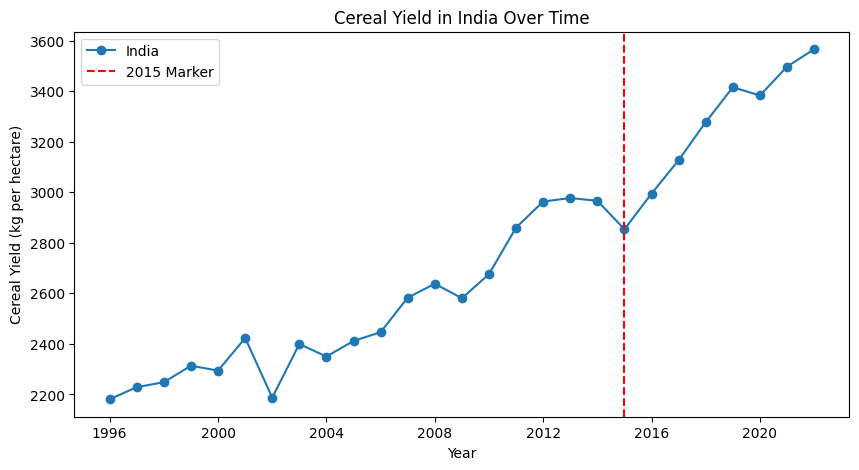

In [ ]:
cereal = {"AG.YLD.CREL.KG": "Cereal Yield"}
ind = ["IND"]

# Making the dataframe
cereals = wbdata.get_dataframe(cereal, country=ind, parse_dates=True)
cereals = cereals.reset_index()
cereals = cereals[cereals['date'].dt.year > 1995]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(cereals['date'], cereals["Cereal Yield"], marker='o', linestyle='-', label="India")
plt.axvline(pd.Timestamp("2015-01-01"), color='r', linestyle='--', label="2015 Marker")

plt.xlabel("Year")
plt.ylabel("Cereal Yield (kg per hectare)")
plt.title("Cereal Yield in India Over Time")

plt.legend()
plt.show()

# Conclusion

Our analysis explored the impact of extreme heat events in Mexico (1998), Spain (2003), and India (2015) on birth rates, death rates, fertility rates, net migration, and agriculture. By examining data from the World Bank, we identified patterns and variations across these countries, revealing that heatwaves impact populations differently depending on socio-economic conditions, demographic composition, and much more.

**Summary of findings:**

- Due to the varying severity of the examined heatwaves, only Spain saw a spike in death rates
- Birth rates were already decreasing in Mexico and India, not much could be attributed to the heatwave
- Spain saw in increase in birth rates due to the denominator of the birth rate formula
- Migration decreasing in India could be attributed to a decrease in movement to heat-impacted urban areas for job seekers
- Cereal yield significantly decreased in India, likely due to a combination of weather patterns which were exacerbated by the heatwave
